# Riemannian Brownian Mixture Model

In [1]:
#Modules

#jax
from jax import jacfwd, vmap
import jax.numpy as jnp
import jax.random as jrandom

#haiku
import haiku as hk

#os
import os

#numpy
import numpy as np

#matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

#other modules
from load_manifold import get_generator_dim, load_manifold

#scores
from models import models

#jaxgeometry
from jaxgeometry.statistics.score_matching import diffusion_mean as dm_score
from jaxgeometry.statistics.score_matching import model_loader
from jaxgeometry.statistics.score_matching import BrownianMixture
from jaxgeometry.statistics.score_matching import ScoreEvaluation
from jaxgeometry.manifolds import *

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
2024-04-25 16:45:41.456763: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Hyper Parameters
T = 0.5
t0 = 0.01
score_path = "scores"
s2_approx = 0
s1loss_type = "dsmvr"
s2loss_type = "dsmvr"
s2_type = "s1s2"
seed = 2712
K = 4

figure_path = '../figures/ml_regression/'
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

In [3]:
def load_score_model(manifold, dim):
    M, x0, sampling_method, generator_dim, layers, opt_val = load_manifold(manifold, dim)
    if "Local" in sampling_method:
        method = "Local"
    else:
        method = "Embedded"
    
    s1_path = ''.join((score_path, f"/{manifold}{dim}/s1_{s1loss_type}/"))
    s2_path = ''.join((score_path, f"/{manifold}{dim}/{s2_type}_{s2loss_type}/"))
    layers = get_generator_dim(generator_dim)

    s1_model = hk.transform(lambda x: models.MLP_s1(dim=generator_dim, layers=layers)(x))
    
    if s2_approx:
        if s2_type == "s2":
            s2_model = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                            dim=generator_dim, r = max(generator_dim//2,1))(x))
        elif s2_type == "s1s2":
            @hk.transform
            def s2_model(x):

                s1s2 =  models.MLP_s1s2(
                    models.MLP_s1(dim=generator_dim, layers=layers), 
                    models.MLP_s2(layers_alpha=layers, 
                                  layers_beta=layers,
                                  dim=generator_dim,
                                  r = max(generator_dim//2,1))
                    )

                return s1s2(x)[1]
    else:
        s2_model = None
        
    s1_state = model_loader.load_model(s1_path)
    if s2_approx:
        s2_state = model_loader.load_model(s2_path)
    else:
        s2_state = None
    
    rng_key = jrandom.PRNGKey(seed)
    s1_fun = lambda x,y,t: s1_model.apply(s1_state.params, rng_key, jnp.hstack((x,y,t)))
    if s2_approx:
        s2_fun = lambda x,y,t: s2_model.apply(s2_state.params, rng_key, jnp.hstack((x,y,t)))
    else:
        s2_fun = None
        
    ScoreEval = ScoreEvaluation(M,
                                s1_model=s1_fun,
                                s2_model=s2_fun,
                                method = method
                                )
                       
    return M, x0, ScoreEval

## Testing with $\mathbb{R}^{2}$

In [4]:
M, x0, ScoreEval = load_score_model("Euclidean", 2)

using M.Exp for Logarithm


### Generate Test Data

In [5]:
eps = 0.1*np.random.normal(size=(100,2))
x = []
centers = [jnp.array([-1.0,0.0]), jnp.array([0.0,1.0]), jnp.array([1.0,0.0]), jnp.array([0.0,-1.0])]
for i in range(K):
    eps = 0.1*np.random.normal(size=(100,2))
    x.append(eps+centers[i])
x = jnp.vstack(x)

X_obs = (x, jnp.zeros(len(x)).reshape(-1))

### Testing with True Gradient

In [6]:
RBMM = BrownianMixture(M=M,
                       grady_log=lambda x,y,t: M.grady_log_hk(x,y,t)[0],
                       gradt_log=lambda x,y,t: M.gradt_log_hk(x,y,t),
                       n_clusters=K,
                       eps=0.00001,
                       method='Local',
                       update_method="Gradient",
                       max_iter=1000,
                       lr=0.01,
                       dt_steps=100,
                       min_t=1e-3,
                       max_t=1.0,
                       seed=2712,
                      )

In [7]:
mu_init = (jnp.stack((X_obs[0][0], X_obs[0][1], X_obs[0][2], X_obs[0][3])),
          jnp.stack((X_obs[1][0], X_obs[1][1], X_obs[1][2], X_obs[1][3])))
mu_init = (jnp.stack((jnp.array([1.0,0.0]), jnp.array([0.0,1.0]), jnp.array([-1.0,0.0]), jnp.array([0.0,-1.0]))),
          jnp.zeros(4).reshape(4,-1))
T = 0.5

In [8]:
RBMM.density((X_obs[0][200], X_obs[1][200].reshape(1)),
            (mu_init[0][0], mu_init[1][0].reshape(1)),
            jnp.array([0.5]))

Array(175.43638657, dtype=float64)

In [9]:
mu_init[0][0]

Array([1., 0.], dtype=float64)

In [10]:
mu_init[0]

Array([[ 1.,  0.],
       [ 0.,  1.],
       [-1.,  0.],
       [ 0., -1.]], dtype=float64)

In [11]:
X_obs[0][0]

Array([-0.89711048, -0.09101539], dtype=float64)

In [12]:
s1_model = lambda x,y,t: M.grady_log_hk(x,y,t)[0]
t = 0.1
T = 0.5
s1_model((mu_init[0][0], mu_init[1][0]), (mu_init[0][0], mu_init[1][0]), T-t)

Array([0., 0.], dtype=float64)

In [13]:
s1_model((mu_init[0][0], mu_init[1][0]), (X_obs[0][0], X_obs[1][0]), T-t)

Array([4.7427762 , 0.22753847], dtype=float64)

In [14]:
RBMM.fit((X_obs[0], X_obs[1].reshape(-1,1)), mu_init=mu_init)

[-400. -400. -400. -400.]
[0.25 0.25 0.25 0.25]
[4.25 4.25 4.25 4.25]
[0.25 0.25 0.25 0.25]


In [15]:
RBMM.mu

(Array([[ 0.01924272,  0.00327201],
        [ 0.00852381,  0.01404561],
        [-0.0023764 ,  0.00327142],
        [ 0.00852321, -0.00757154]], dtype=float64),
 Array([[0.],
        [0.],
        [0.],
        [0.]], dtype=float64))

In [16]:
RBMM.T

Array([0.52134035, 0.52135358, 0.52138405, 0.52137035], dtype=float64)

In [17]:
RBMM.pi

Array([0.25, 0.25, 0.25, 0.25], dtype=float64)

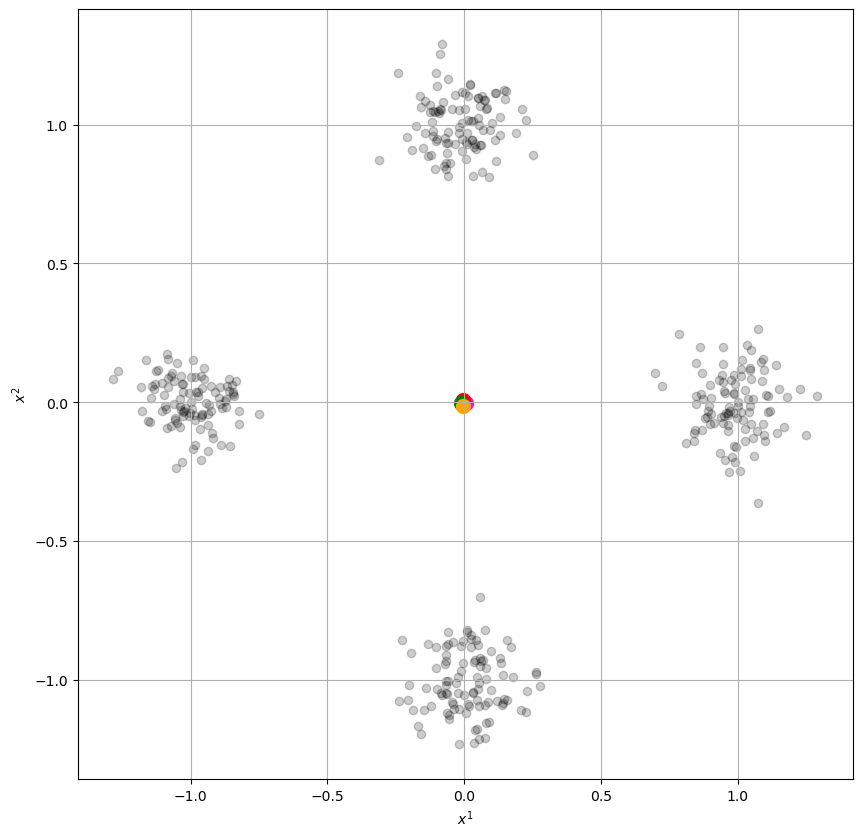

In [57]:
color = ['magenta', 'red', 'green', 'orange']
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i in range(K):
    ax.scatter(RBMM.mu[0][i,0], RBMM.mu[0][i,1], alpha=1.0, s=100, color=color[i])
ax.scatter(X_obs[0][:,0], 
           X_obs[0][:,1], alpha=0.2, color="black", label='Cluser ' + str(i+1))
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
ax.grid(True)

In [95]:
pt = vmap(lambda x,c: vmap(lambda mu_x,mu_c,t: RBMM.test((x,c),(mu_x,mu_c), t))(RBMM.mu[0],
                                                                                    RBMM.mu[1],
                                                                                    RBMM.T))(X_obs[0],
                                                                                                        X_obs[1])

In [96]:
pt[-1]

Array([[4.93732834e-071, 1.56921535e-070, 2.58408404e-070,
        2.73077854e-070],
       [1.55901190e-033, 2.85087806e-033, 2.14374250e-033,
        4.01094940e-033],
       [2.62072496e-105, 9.91658070e-105, 1.51087139e-104,
        1.91020877e-104],
       ...,
       [9.27946025e-069, 7.14824220e-068, 3.41643483e-065,
        1.09456625e-067],
       [2.00339820e-061, 1.59857470e-060, 5.85607725e-058,
        2.56573204e-060],
       [2.46697727e-090, 3.44668754e-089, 3.93876309e-086,
        6.61653472e-089]], dtype=float64)

In [97]:
pt[0]

Array([[8.66187043e-069, 2.75297470e-068, 4.53342367e-068,
        4.79077920e-068],
       [2.73507414e-031, 5.00147745e-031, 3.76090438e-031,
        7.03666469e-031],
       [4.59770517e-103, 1.73972909e-102, 2.65061818e-102,
        3.35120124e-102],
       ...,
       [1.62795498e-066, 1.25406178e-065, 5.99366981e-063,
        1.92026748e-065],
       [3.51468942e-059, 2.80448168e-058, 1.02736903e-055,
        4.50122757e-058],
       [4.32797578e-088, 6.04674408e-087, 6.91002365e-084,
        1.16078094e-086]], dtype=float64)

In [98]:
RBMM.mu[0]

Array([[-0.00019094,  0.01014752],
       [-0.00270702,  0.00327996],
       [-0.001678  , -0.01599399],
       [-0.00416253,  0.00165014]], dtype=float64)

In [99]:
pt[1][0][:,0]

Array([[-5.81368416e-02,  1.57382457e-03],
       [-4.14709138e-02,  9.60881242e-03],
       [-7.04548934e-02,  1.62472355e-03],
       [-5.38976261e-02,  8.51013940e-03],
       [-5.53627427e-02,  1.54624472e-02],
       [-5.11296274e-02,  1.40099209e-02],
       [-4.78863577e-02, -3.39589615e-03],
       [-4.71107219e-02,  6.19191866e-03],
       [-6.82478614e-02,  5.36489172e-03],
       [-5.21966181e-02,  4.85475733e-03],
       [-5.51939833e-02,  1.58409740e-03],
       [-5.77826171e-02,  1.45333459e-02],
       [-5.83896523e-02,  6.85555715e-04],
       [-6.56521681e-02,  1.17559644e-02],
       [-6.73882266e-02,  1.36883394e-02],
       [-5.60392537e-02,  9.18737938e-03],
       [-6.21498223e-02,  1.62370565e-02],
       [-6.11115208e-02, -3.50357267e-03],
       [-5.73192615e-02,  1.48508667e-02],
       [-6.86092294e-02, -1.66152914e-03],
       [-5.45403990e-02,  4.37482633e-03],
       [-6.36512729e-02,  1.39677078e-02],
       [-5.21178853e-02,  6.16426002e-03],
       [-6.

In [55]:
RBMM.p0((X_obs[0][10], X_obs[1][10]), (RBMM.mu[0][0], RBMM.mu[1][0]), 0.5)

Array(0., dtype=float64)